In [1]:

import json
import csv
import os
from itertools import islice
import matplotlib.pyplot as plt

import lib.basic_measurement as basic
import lib.by_ns as by_ns
import lib.plot as plot

- determine whether a resolver has a shared frontend cache
- i.e. determine whether successive queries within the same TTL are answered from cache
- also plot the TTL line

In [2]:


# Working directory
dataset_dir = "public1000/"

# Data Source
db_path = dataset_dir + "combined/"
# File suffix filter
pattern_suffix = "-shared"

# Output
outfile = dataset_dir + "shared.csv"

In [6]:

with open(outfile, 'w') as of: # open outfile
  # Prepare output file
  fieldnames = ["ns", "vp", "shared", "single"]
  writer = csv.DictWriter(of, fieldnames=fieldnames)
  writer.writeheader()
  
  # Walk database directory 
  for root, dirs, files in os.walk(db_path):
    for file in files:
      
      # Skip files that are not of the pattern we want
      if not file.endswith(pattern_suffix): 
        continue
      fn = os.path.join(root, file)

      with open(fn, 'r') as f: # open nameserver file

        # Read, parse, filter data 
        data = [basic.BasicMeasurement(json.loads(l)) for l in f if l != "\n"]
        data = [d for d in data if d.cs_shared_frontend()]
        if len(data) == 0:
          continue

        ns = by_ns.NameserverMeasurement(data, data[0].get_nameserver())
        
        # Prepare output
        for vp in ns.get_vantagepoints():
          bm = ns.get_basic_measurements(vp)[0]
          r = {
            "ns": ns.get_nameserver(),
            "vp": vp,
            "shared": bm.shared_frontend(),
            "single": bm.is_single()
          }


          # Write to output file
          writer.writerow(r)


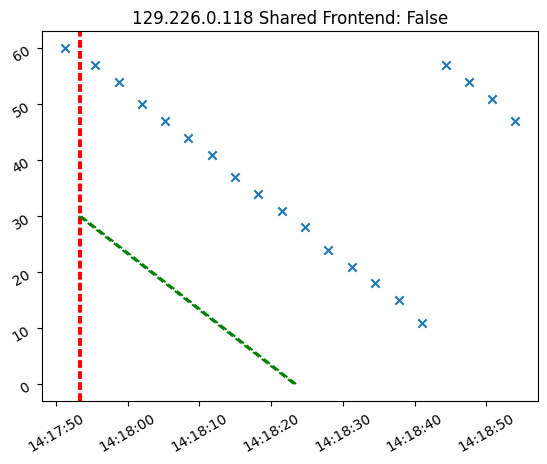

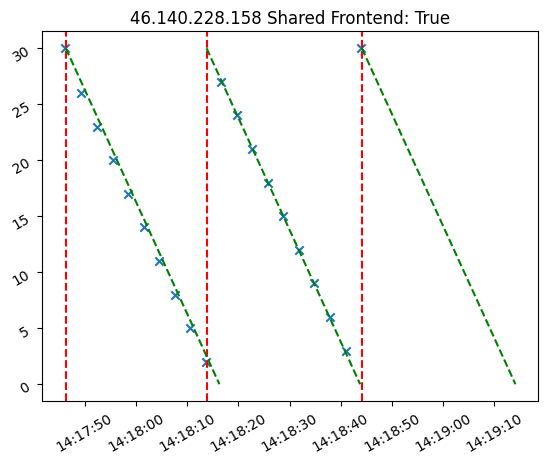

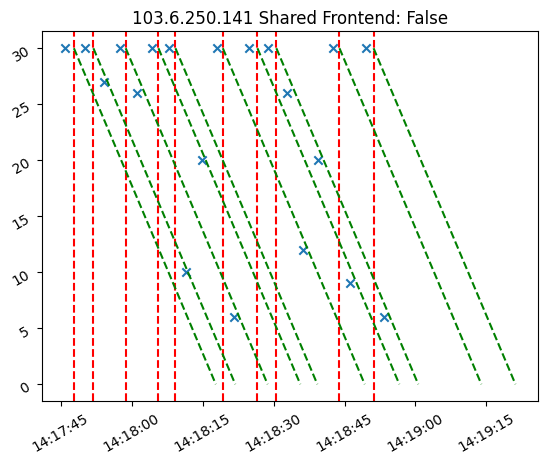

In [6]:

picks = [
  "129.226.0.118", # TTL rewriting
  "46.140.228.158", #prefetching
  "103.6.250.141"
]

LIMIT = 24
num_loaded = 0
# Walk database directory 
for root, dirs, files in os.walk(db_path):
  if num_loaded >= LIMIT:
    break
  for file in files:

    # Skip files that are not of the pattern we want
    if not file.endswith(pattern_suffix): 
      continue
    fn = os.path.join(root, file)

    if file.split("-")[0] not in picks: # only pick a few
      continue

    with open(fn, 'r') as f: # open nameserver file

      # Read, parse, filter data 
      sample = [basic.BasicMeasurement(json.loads(l)) for l in f if l != "\n"]
      sample = [d for d in sample if d.cs_shared_frontend()]

      #for s in sample:
      fig, ax = plt.subplots()
      plot.subplot_ttl_line(sample[0], ax)
